# NBS <a id='network-based-statistic'></a>


    '''
    Performs the NBS for populations X and Y for a t-statistic threshold of
    alpha.
    Parameters
    ----------
    x : NxNxP np.ndarray
        matrix representing the first population with P subjects. must be
        symmetric.
    y : NxNxQ np.ndarray
        matrix representing the second population with Q subjects. Q need not
        equal P. must be symmetric.
    thresh : float
        minimum t-value used as threshold
    k : int
        number of permutations used to estimate the empirical null 
        distribution
    tail : {'left', 'right', 'both'}
        enables specification of particular alternative hypothesis
        'left' : mean population of X < mean population of Y
        'right' : mean population of Y < mean population of X
        'both' : means are unequal (default)
    paired : bool
        use paired sample t-test instead of population t-test. requires both
        subject populations to have equal N. default value = False
    verbose : bool
        print some extra information each iteration. defaults value = False
    seed : hashable, optional
        If None (default), use the np.random's global random state to generate random numbers.
        Otherwise, use a new np.random.RandomState instance seeded with the given value.

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images
from bct import nbs
from scipy.io import savemat
from mne.viz import plot_connectivity_circle

/usr/local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
data_dir = '/Volumes/psybrain/ADM/derivatives'
results_dir = '/Volumes/schnyer/Megan/adm_mem-fc/analysis/stats/'
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries'

tasks = ['MemMatch1', 'MemMatch2', 'MemMatch3']
trial_types = ['cue', 'match', 'mismatch']

atlas_file='/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz'
atlas_lut='/Volumes/psybrain/ADM/derivatives/nibs/power264_labels.tsv'

In [3]:
atlas = pd.read_csv(atlas_lut, sep='\t').set_index('index')

dmn = atlas.loc[atlas['regions'].str.contains('Default')].index.tolist()
fpn = atlas.loc[atlas['regions'].str.contains('Fronto-parietal')].index.tolist()
dmn_fpn = np.concatenate((dmn, fpn))

In [4]:
from nilearn import datasets

power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

## From Matlab NBS

In [5]:
x = np.load('/Volumes/psybrain/ADM/derivatives/nibs/memmatch_fc.npy', allow_pickle=True).flat[0]
fc_subs = np.loadtxt('/Volumes/psybrain/ADM/derivatives/nibs/fcsubs.txt', dtype=str)

In [6]:
adj = np.loadtxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/adj_dmn_ya_gt_oa_t-35_k-5000_extent.txt')
print(adj.shape)
nbs_mat = np.repeat(adj[:, :, np.newaxis], x['cue'].shape[2], axis=2)*x['cue'][dmn][:,dmn,:]
np.nonzero(nbs_mat[:,:,0])
edges_fc = nbs_mat[np.nonzero(np.triu(nbs_mat[:,:,0]))]
edges_fc.shape

(58, 58)


(4, 88)

In [7]:
x['cue'][dmn][:,dmn,:].shape

(58, 58, 88)

(<Figure size 1080x1080 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x12dfa0dd0>)

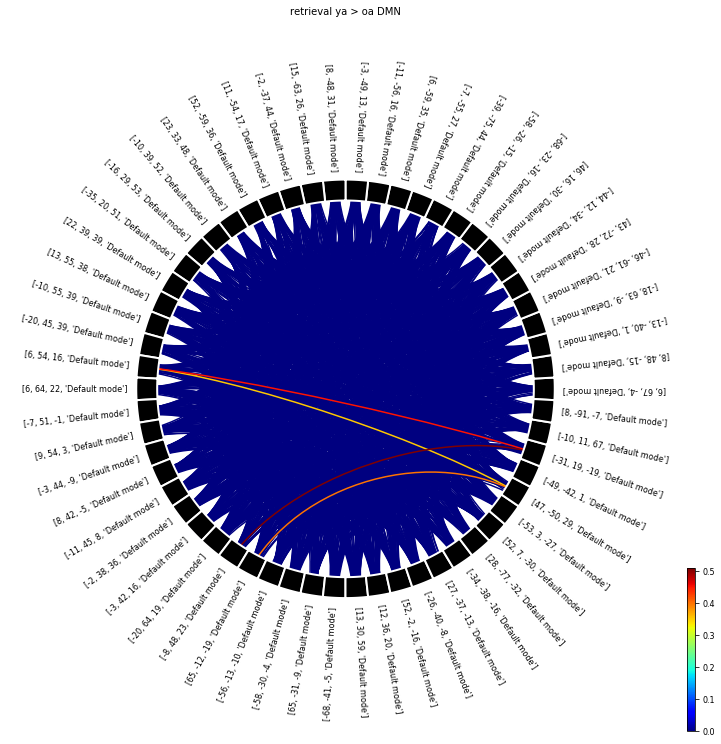

In [8]:
fig = plt.figure(figsize=(15, 15))
n_lines = int(np.sum((nbs_mat > 0) / 2))
node_labels = pd.DataFrame(np.hstack((coords[dmn], atlas.loc[dmn].values))).values.tolist()


plot_connectivity_circle(nbs_mat.mean(axis=2), node_labels, n_lines=n_lines, fig=fig, title='retrieval ya > oa DMN', 
                         fontsize_title=10, facecolor='white', textcolor='black', 
                         colormap='jet', colorbar=1, node_colors=['black'], 
                         node_edgecolor=['white'], show=False, interactive=False)

In [9]:
from nilearn import plotting
from matplotlib import cm

plotting.plot_connectome(nbs_mat.mean(axis=2), coords[dmn], 
                         node_size=0.01, edge_cmap=cm.gist_gray,
                        output_file = results_dir + 'glass_brain.png')

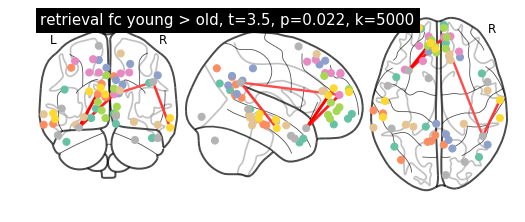

In [10]:
from nilearn import plotting

plotting.plot_connectome(nbs_mat.mean(axis=2), coords[dmn], edge_threshold=0, title='retrieval fc young > old, t=3.5, p=0.022, k=5000')


In [11]:
nbs_mat.shape

(58, 58, 88)

In [12]:
fc_subs[:87]

array(['30004', '30008', '30009', '30015', '30019', '30020', '30023',
       '30040', '30057', '30064', '30066', '30069', '30074', '30085',
       '30088', '30090', '30091', '30095', '30096', '30105', '30116',
       '30118', '30119', '30128', '30181', '30217', '30227', '30236',
       '30242', '30255', '30274', '30283', '30295', '30330', '30346',
       '30376', '30395', '30400', '30403', '30412', '30426', '30432',
       '30466', '30469', '30478', '30568', '30570', '30581', '30584',
       '30588', '40160', '40170', '40175', '40288', '40351', '40490',
       '40512', '40519', '40520', '40524', '40547', '40564', '40615',
       '40619', '40624', '40638', '40649', '40650', '40656', '40658',
       '40664', '40665', '40668', '40672', '40685', '40694', '40720',
       '40738', '40743', '40750', '40778', '40796', '40803', '40855',
       '40861', '40961', '40968'], dtype='<U5')

In [13]:
edges_df = pd.DataFrame( edges_fc[:,:87] )
edges_df.columns = fc_subs[:87]
edges_df = edges_df.transpose()
# edges_df = edges_df[:87]

cols = []
for col in edges_df.columns: cols.append("edge_" + str(col))
edges_df.columns = cols

edges_df.to_csv('/Volumes/schnyer/Megan/adm_mem-fc/analysis/edges_df.csv')
edges_df

,edge_0,edge_1,edge_2,edge_3
30004,0.451471,0.509899,0.257227,0.688757
30008,0.425655,0.824386,1.032888,0.311497
30009,0.508419,0.634550,0.578941,0.278736
30015,0.264530,0.418911,0.402329,0.096133
30019,0.365178,0.379545,0.701750,0.334316
30020,1.129555,0.482186,0.290999,1.015736
30023,0.193597,0.437271,0.817750,0.375620
30040,0.670385,0.435313,0.287747,0.322722
30057,0.072768,0.378579,0.562540,0.173406
30064,0.643378,0.987714,1.129634,0.696325


In [14]:
fc_edges = [(28, 53), (39, 53), (28, 55), (38, 55)]
fc_edges0 = [28, 28, 38, 39]
fc_edges1 = [53, 55, 55, 53]

print(coords[dmn][fc_edges0])
print(coords[dmn][fc_edges1])
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/dmn_t-31_edges0.txt', coords[dmn][fc_edges0], delimiter = ',', fmt='%s')
np.savetxt('/Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs/dmn_t-31_edges1.txt', coords[dmn][fc_edges1], delimiter = ',', fmt='%s')


[[  6  54  16]
 [  6  54  16]
 [ -8  48  23]
 [ 65 -12 -19]]
[[ 47 -50  29]
 [-31  19 -19]
 [-31  19 -19]
 [ 47 -50  29]]


In [15]:
%%bash

cd /Volumes/schnyer/Megan/adm_mem-fc/analysis/nbs
i=1
for coord in `cat dmn_t-31_edges0.txt`; do
    echo $i
    echo $coord
    atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c $coord
    echo `cat dmn_t-31_edges1.txt | head -$i | tail -1`
    atlasquery -a 'Harvard-Oxford Cortical Structural Atlas' -c `cat dmn_t-31_edges1.txt | head -$i | tail -1`
    printf '\n\n'
    ((i=i+1))
done

1
6,54,16
<b>Harvard-Oxford Cortical Structural Atlas</b><br>39% Paracingulate Gyrus, 19% Superior Frontal Gyrus, 15% Frontal Pole
47,-50,29
<b>Harvard-Oxford Cortical Structural Atlas</b><br>51% Angular Gyrus, 4% Supramarginal Gyrus, posterior division


2
6,54,16
<b>Harvard-Oxford Cortical Structural Atlas</b><br>39% Paracingulate Gyrus, 19% Superior Frontal Gyrus, 15% Frontal Pole
-31,19,-19
<b>Harvard-Oxford Cortical Structural Atlas</b><br>82% Frontal Orbital Cortex


3
-8,48,23
<b>Harvard-Oxford Cortical Structural Atlas</b><br>34% Paracingulate Gyrus, 20% Superior Frontal Gyrus, 1% Frontal Pole
-31,19,-19
<b>Harvard-Oxford Cortical Structural Atlas</b><br>82% Frontal Orbital Cortex


4
65,-12,-19
<b>Harvard-Oxford Cortical Structural Atlas</b><br>65% Middle Temporal Gyrus, posterior division, 13% Middle Temporal Gyrus, anterior division
47,-50,29
<b>Harvard-Oxford Cortical Structural Atlas</b><br>51% Angular Gyrus, 4% Supramarginal Gyrus, posterior division


